<h1>Learning Blackjack with Q-Learning</h1>

<img src="files/cards.jpg">

This notebook explores the game of Blackjack, and attempts by an agent to learn an optimal strategy to win (or minimize losses) over several hands. This was created with the goal to learn more about object oriented programing in python and Q-learning rather than an actual attempt to "beat" the game. A simplified version of the rules was used:

<h3>The Rules</h3>

1. The player is dealt 2 cards from an infinite deck. Since the deck is infinite, knowledge about the player's cards does not provide any knowledge about the dealer's cards or about the card that will be drawn next.

2. The player then has the option to "hit" or "stand".  If the player chooses to hit, he is dealt another card.

3. Step 2 is repeated until either the player chooses to stand, or the players hand value is greater than 21.

4. If the players hand value is greater than 21, then he busts, the dealer wins, and the hand is over.

5. If the players hand value is less than or equal to 21 then the dealer must make a turn.

6. During the dealers hand, the dealer must continue to hit while his hand value is less than 17.  When the dealer's hand value is 17 or over, the dealer stands and the hand is over.

7. If the dealer's hand value is over 21, the dealer busts, the player wins, and the hand is over.

8. If neither player went bust during his turn, then whoever has the higher hand value wins. If the player and the dealer have the same hand value then the game is a draw.

<h3>Code</h3>

The code to implement the rules and train the agent are located in https://github.com/charlieaxle/blackjack-qlearn/blob/master/blackjack.py.  

In [1]:
import blackjack

<h5>Card</h5>

In [2]:
help(blackjack.Card)

Help on class Card in module blackjack:

class Card(builtins.object)
 |  Card(card_type=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, card_type=None)
 |      Initializes a new Card object
 |      
 |      Params:
 |          type (string): Type of card, i.e. "7" or "A". If None, random Card is selected.
 |      
 |      Object Attributes:
 |          type (string): The type of card, i.e. "7" or "A"
 |          value (string): The value of the card
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



<h5>Hand</h5>

In [3]:
help(blackjack.Hand)

Help on class Hand in module blackjack:

class Hand(builtins.object)
 |  Hand(initial_cards=0)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, initial_cards=0)
 |      Initializes a new Hand object
 |      
 |      Object Attributes:
 |          cards (list): A list that may contain multiple Card objects
 |          score (int): The current value of the cards in the hand
 |          busted (boolean): True if hand is bust, otherwise False
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  deal_card(self, num_cards=1)
 |      Used to add card(s) to Hand object
 |      
 |      Params:
 |          num_cards(int, default=1): Number of cards to add
 |      Returns:
 |          None
 |  
 |  get_score(self)
 |      Used to access the current score of a Hand object
 |      Params: None
 |      Returns: self.score
 |  
 |  possible_moves(self)
 |      Used to get possible moves available to a hand'
 |      
 |      Params:
 |          None
 |      Returns:
 |          List of pos

In [4]:
help(blackjack.BlackjackGame)

Help on class BlackjackGame in module blackjack:

class BlackjackGame(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initializes a new BlackjackGame object
 |      
 |              
 |      Attributes:
 |          turn (string): "player" or "dealer" depending on current turn
 |          winner (string): Winner of hand
 |          over (boolean): True if hand is over, otherwise False
 |          player_hand (Hand): Player's current hand
 |          dealer_hand (Hand): Dealer's current hand
 |          game_state (tuple): Tuple containing player hand value and dealer hand value
 |  
 |  dealer_move(self)
 |      Function that makes the dealer make one move. Dealer's move is restricted by rules
 |      
 |      Params:None
 |      Returns:None
 |  
 |  player_allowed_moves(self)
 |      Function to get moves availbe to player based on current hand
 |      
 |      Params:None
 |      Reutnrs: List of possible moves
 |  
 |  player_move(self, move)
 |      Allow

In [5]:
help(blackjack.Agent)

Help on class Agent in module blackjack:

class Agent(builtins.object)
 |  Agent(money=0, epsilon=0.1, learning_rate=0.5, discount=0.2)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, money=0, epsilon=0.1, learning_rate=0.5, discount=0.2)
 |      Initializes a new Agent object
 |      
 |      Parameters:
 |          money (int, default=0): How much money Agent starts with
 |          epsilon (float, default=.1): Float between 0 and 1. Used for Epsilon-Greedy algorithm.
 |          learning_rate (float, default=.5): Learning rate in Q-learning algorithm
 |          discount (float, default=.2): Discount in Q-learning algorithm
 |      
 |      Object Attributes:
 |          money (int): Amount of money agent currently has
 |          epsilon, learning_rate, discount (float): As initialized. Will not change, unless reset
 |          Q (dictionary): Table of Q-values. Each entry in form: (game state): {"hit":Q-value, "stand":Q-value}
 |              *Q initialized for 0 Q-value fo

<h3>Baseline Performance</h3>

Before attempting to measure the performance of the Q-learning algorithm, we need to find a "baseline" to use for comparison. While we could use some basic strategy for this measurement (i.e. always hit when the player's hand is valued at 11 or less), the Agent's strategy did not include any of this prior information as the Q table is intiialized so that "hit" and "stand" have equal value for any given game state. If we let the Agent play before doing any learning, his strategy is to either "hit" or "stand" at random every turn.

In [2]:
import random
random.seed(1)

#initialize agent with $10,000
agent = blackjack.Agent(money=10000)

#make agent play 10,000 hands
agent.play(10000)

{'money_left': 5685, 'return_rate': -0.4315}

We can see that after 10,000 hands, the Agent is down to $5,685 and has a overall return of ~ -43% of is initial money. As expected, this is a very poor performance

<h3>Training the Agent</h3>

First we run a quick experiment to confirm that the Q-learning algorithm helps the Agent improve his Blackjack strategy.  To do this we can plot the agents performance as a function of the number of hands he learns from.

In [17]:
learning_hands = []
results = []
random.seed(1)

for i in range(0, 3000, 100):
    #initialize a new Agent with $10000
    agent = blackjack.Agent(money=10000)
    
    #train the Agent for "i" hands of Blackjack
    agent.learn(num_hands = i)
    res = agent.play(10000)
    
    #store results
    learning_hands.append(i)
    results.append(res['return_rate'])

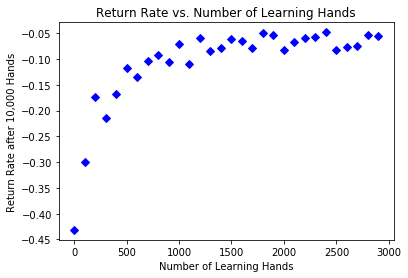

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.plot(learning_hands, results, 'bD')
plt.title("Return Rate vs. Number of Learning Hands")
plt.xlabel("Number of Learning Hands")
plt.ylabel("Return Rate after 10,000 Hands")
plt.show()

The learning curve shows a signficiant increase in performance after the Agent is allowed to learn by playing more practice hands. As expected the rate of return remains negative, but increases sharply up to around 1000 learning hands and then begins to level off. It seems that performance is maximized after around 1500 learning hands at which point the Agent cannot improve his strategy anymore. After this point variations in perfromance are likely due to the random nature of Blackjack.

In [32]:
import numpy as np
np.linspace(.1,.9,9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [50]:
learning_rate_results = {}


for k in [.01,.99]:
    learning_hands = []
    results = []
    random.seed(1)

    for i in range(0, 1500, 50):
        #initialize a new Agent with $10000
        agent = blackjack.Agent(money=10000, discount=k)

        #train the Agent for "i" hands of Blackjack
        agent.learn(num_hands = i)
        res = agent.play(10000)

        #store results
        learning_hands.append(i)
        results.append(res['return_rate'])
    learning_rate_results[k] = [learning_hands, results]

In [37]:
learning_rate_results

{0.1: [[0,
   100,
   200,
   300,
   400,
   500,
   600,
   700,
   800,
   900,
   1000,
   1100,
   1200,
   1300,
   1400,
   1500,
   1600,
   1700,
   1800,
   1900,
   2000,
   2100,
   2200,
   2300,
   2400,
   2500,
   2600,
   2700,
   2800,
   2900],
  [-0.4315,
   -0.2996,
   -0.1728,
   -0.14,
   -0.1343,
   -0.1131,
   -0.1017,
   -0.1126,
   -0.1183,
   -0.0697,
   -0.0635,
   -0.1005,
   -0.0685,
   -0.0989,
   -0.0761,
   -0.0796,
   -0.0791,
   -0.0654,
   -0.0792,
   -0.0625,
   -0.063,
   -0.0776,
   -0.0576,
   -0.0711,
   -0.0608,
   -0.083,
   -0.0731,
   -0.0555,
   -0.0625,
   -0.073]],
 0.3: [[0,
   100,
   200,
   300,
   400,
   500,
   600,
   700,
   800,
   900,
   1000,
   1100,
   1200,
   1300,
   1400,
   1500,
   1600,
   1700,
   1800,
   1900,
   2000,
   2100,
   2200,
   2300,
   2400,
   2500,
   2600,
   2700,
   2800,
   2900],
  [-0.4315,
   -0.2996,
   -0.1726,
   -0.1835,
   -0.1541,
   -0.134,
   -0.1083,
   -0.0985,
   -0.1086,
   -0.09

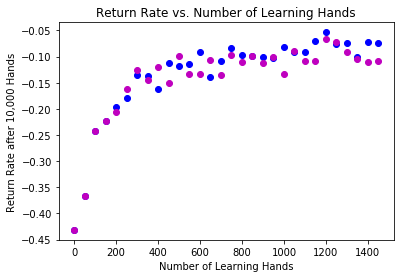

In [51]:
plt.plot(learning_rate_results[.01][0], learning_rate_results[.01][1], 'bo')
#plt.plot(learning_rate_results[.3][0], learning_rate_results[.3][1], 'ro')
#plt.plot(learning_rate_results[.6][0], learning_rate_results[.6][1], 'go')
plt.plot(learning_rate_results[.99][0], learning_rate_results[.99][1], 'mo')
plt.title("Return Rate vs. Number of Learning Hands")
plt.xlabel("Number of Learning Hands")
plt.ylabel("Return Rate after 10,000 Hands")
plt.show()